<a href="https://colab.research.google.com/github/Devansh-0/Vision-Transformer-5-Flower-Classification/blob/main/Vision_Transformer_5_Flower_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets

In [ ]:
from datasets import load_dataset

train_ds = load_dataset('miladfa7/5-Flower-Types-Classification-Dataset')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_ds = train_ds['train'].train_test_split(test_size=0.15)
train_data = train_ds['train']
test_data = train_ds['test']

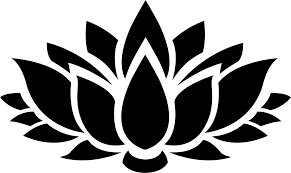

In [ ]:
train_data[52]['image']

In [ ]:
label = list(set(train_data['label']))
id2label = {id:label for id, label in enumerate(label)}
label2id = {label:id for id,label in id2label.items()}
print(id2label, label2id)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4} {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [ ]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [ ]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            # CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [ ]:
# Set the transforms
train_data.set_transform(train_transforms)
# val_ds.set_transform(val_transforms)
test_data.set_transform(val_transforms)

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_data, collate_fn=collate_fn, batch_size=4)
test_dataloader = DataLoader(test_data, collate_fn=collate_fn, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [ ]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pip install accelerate==0.21.0

In [ ]:
import accelerate

print("Accelerate version:", accelerate.__version__)

Accelerate version: 0.21.0


In [ ]:
!pip install torch==2.0.0+cu117
!pip install pytorch-lightning==1.9.4
!pip install accelerate==0.21.0
!pip install tokenizers==0.13.3
!pip install transformers==4.26.1


ERROR: Could not find a version that satisfies the requirement torch==2.0.0+cu117 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1)
ERROR: No matching distribution found for torch==2.0.0+cu117


In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    "5-Flower-Types-Classification",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5, #0.00002
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [ ]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4249
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 665
  Number of trainable parameters = 85802501


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.387186,0.972000
2,No log,0.205787,0.977333
3,No log,0.153166,0.981333
4,0.385600,0.125732,0.992000
5,0.385600,0.119379,0.993333


***** Running Evaluation *****
  Num examples = 750
  Batch size = 4
Saving model checkpoint to 5-Flower-Types-Classification/checkpoint-133
Configuration saved in 5-Flower-Types-Classification/checkpoint-133/config.json
Model weights saved in 5-Flower-Types-Classification/checkpoint-133/pytorch_model.bin
Image processor saved in 5-Flower-Types-Classification/checkpoint-133/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 750
  Batch size = 4
Saving model checkpoint to 5-Flower-Types-Classification/checkpoint-266
Configuration saved in 5-Flower-Types-Classification/checkpoint-266/config.json
Model weights saved in 5-Flower-Types-Classification/checkpoint-266/pytorch_model.bin
Image processor saved in 5-Flower-Types-Classification/checkpoint-266/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 750
  Batch size = 4
Saving model checkpoint to 5-Flower-Types-Classification/checkpoint-399
Configuration saved in 5-Flower-Types-Classification/ch

TrainOutput(global_step=665, training_loss=0.31718953354914386, metrics={'train_runtime': 981.15, 'train_samples_per_second': 21.653, 'train_steps_per_second': 0.678, 'total_flos': 1.6463615856262042e+18, 'train_loss': 0.31718953354914386, 'epoch': 5.0})

In [ ]:
final_model= trainer.train()

***** Running training *****
  Num examples = 4249
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 665
  Number of trainable parameters = 85802501


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.119379,0.993333
2,No log,0.119379,0.993333
3,No log,0.119379,0.993333
4,0.103300,0.119379,0.993333
5,0.103300,0.119379,0.993333


***** Running Evaluation *****
  Num examples = 750
  Batch size = 4
Saving model checkpoint to 5-Flower-Types-Classification/checkpoint-133
Configuration saved in 5-Flower-Types-Classification/checkpoint-133/config.json
Model weights saved in 5-Flower-Types-Classification/checkpoint-133/pytorch_model.bin
Image processor saved in 5-Flower-Types-Classification/checkpoint-133/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 750
  Batch size = 4
Saving model checkpoint to 5-Flower-Types-Classification/checkpoint-266
Configuration saved in 5-Flower-Types-Classification/checkpoint-266/config.json
Model weights saved in 5-Flower-Types-Classification/checkpoint-266/pytorch_model.bin
Image processor saved in 5-Flower-Types-Classification/checkpoint-266/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 750
  Batch size = 4
Saving model checkpoint to 5-Flower-Types-Classification/checkpoint-399
Configuration saved in 5-Flower-Types-Classification/ch

***** Running Prediction *****
  Num examples = 750
  Batch size = 4


{'test_loss': 0.11937881261110306, 'test_accuracy': 0.9933333333333333, 'test_runtime': 20.8396, 'test_samples_per_second': 35.989, 'test_steps_per_second': 9.021}


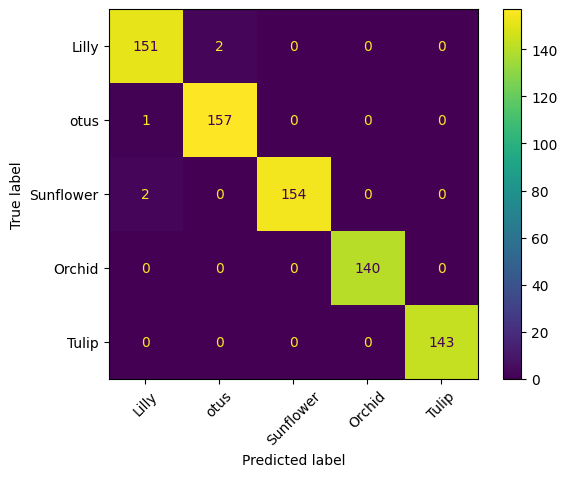

In [ ]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ["Lilly", "otus", "Sunflower","Orchid", "Tulip"]
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
"https://hips.hearstapps.com/hmg-prod/images/mourning-lilies-royalty-free-image-1652478624.jpg"